In [22]:
########################################
#LIBRARIES

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import sklearn
import os

########################################
#PARAMETERS
nTimeSteps = 60; #at 60 Hz
epochs = 100
minibatch_size= 50
hiddenlayers = [100]
input_size = 25
samples_per_file = 1000
use_case = 'qhold'
learning_rate = 0.01
LRdecay = 0.7
model_file_path = '../Trained_Models/'
sample_file_path = f'../Data/Samples/data_{use_case}_{nTimeSteps}tsteps_1535/'
simulation_file_path = f'../Data/Simulations/pm_target.sim'
objective_file_path = f'../Data/Objectives/pm_{use_case}.obj'
# set log level
dde.set_log_level(dde.LogLevel.off)
print(os.listdir(sample_file_path))

############################################
#LOAD SIMULATION PYDDE_V2
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init_0 = np.zeros(dyn.p0.size*nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(nTimeSteps):
	p_init_0[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init_0)
q_0 = dyn.q0
qdot_0 = dyn.qdot0
qddot_0 = dyn.qddot0
r = dyn.r(state_init, p_init_0)
dr = dyn.dr_dp(state_init, p_init_0)
dq = dyn.dq_dp(state_init, p_init_0)
dyn_json = json.load(open(simulation_file_path))

#OBJECTIVE
obj = dde.InverseObjective(dyn)
objective_json = json.load(open(objective_file_path))
obj.loadJson(objective_json)

#############################################
#GENERATE OPTIMIZATION
opt = dde.Newton()

['data_1.json', 'qhold.out', 'data_16.json', '.DS_Store', 'data_0.json', 'data_10.json', 'data_7.json', 'data_test', 'data_6.json', 'data_11.json', 'Description.json', 'data_9.json', 'data_12.json', 'data_5.json', 'data_4.json', 'data_8.json', 'data_13.json', 'data_3.json', 'data_14.json', 'data_15.json', 'data_2.json']


In [18]:
#########################################
#LOAD SAMPLES
number_of_files = len(os.listdir(sample_file_path))-4
samplenum = samples_per_file*number_of_files
output_size = dyn.nParameters*nTimeSteps


p = np.zeros(( samplenum, dyn.nParameters*nTimeSteps))
q = np.zeros((samplenum, dyn.nDofs))
loss = np.zeros(samplenum)
qdot = np.zeros((samplenum,dyn.nDofs))
qddot = np.zeros((samplenum,dyn.nDofs))
p_now  = np.zeros((samplenum,dyn.nParameters))

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q'])
        for i, p_i in enumerate(data['p']):
            p[filenum*filesize+i, :] = np.array(p_i)
        for s, q_s in enumerate(data['q']):
            q[filenum*filesize+s, :] = np.array(q_s)
        for i, p_now_s in enumerate(data['p_now']):
            p_now[filenum*filesize+i, :] = np.array(p_now_s)
        for i, qdot_s in enumerate(data['qdot']):
            qdot[filenum*filesize+i, :] = np.array(qdot_s)
        for i, qddot_s in enumerate(data['qddot']):
            qddot[filenum*filesize+i, :] = np.array(qddot_s)
        for i, truth in enumerate(data['loss']):
            loss[filenum*filesize+i] = np.array(truth)
print(q.shape)
print(p.shape)
indices_to_delete = []
for d in range(samplenum):
    if loss[d] > 0.01:
        indices_to_delete.append(d)
q1 = np.delete(q, indices_to_delete, 0)
print(q1.shape)
print(p[3000, :])
print(q[3000, :])
print(p_now[3000, :])
print(qdot[3000, :])

(17000, 3)
(17000, 180)
(16985, 3)
[0.42269563 1.1758365  0.40933441 0.43665098 1.17627688 0.4075307
 0.45056557 1.17662223 0.40558548 0.46440673 1.17692811 0.4035255
 0.47814646 1.17724445 0.40137776 0.49176162 1.1776147  0.39916885
 0.50523386 1.17807546 0.39692435 0.51854943 1.17865664 0.39466845
 0.5316987  1.17938179 0.39242364 0.54467568 1.18026874 0.39021054
 0.55747749 1.18133038 0.38804783 0.57010375 1.1825754  0.38595226
 0.58255607 1.18400912 0.38393872 0.59483754 1.18563417 0.38202037
 0.60695222 1.1874512  0.38020876 0.6189048  1.18945944 0.37851396
 0.63070019 1.19165716 0.37694474 0.64234324 1.19404212 0.3755087
 0.65383848 1.1966118  0.37421233 0.66518986 1.19936372 0.3730612
 0.67640061 1.20229551 0.37205994 0.68747303 1.20540508 0.37121235
 0.69840839 1.20869058 0.37052139 0.70920671 1.21215044 0.36998921
 0.71986672 1.21578324 0.36961706 0.73038571 1.2195876  0.36940529
 0.74075938 1.22356201 0.36935323 0.75098176 1.22770456 0.36945915
 0.76104514 1.23201271 0.369720

In [29]:
#Change DynamicSequence
sample = 30
for l in range(dyn.nDofs):
    dyn_json["simulation"]["q"][l] = [q[sample,l]] 
    dyn_json["simulation"]["qdot"][l] = [qdot[sample,l]] 
    dyn_json["simulation"]["qddot"][l] = [qddot[sample,l]] 
for l in range(dyn.nParameters):
    dyn_json["simulation"]["p"][l] = [p_now[sample,l]] 
dyn.loadJson(dyn_json, nTimeSteps)
dyn.p0 = p_now[sample,:]
for s in range(nTimeSteps):
    p_init[s*dyn.p0.size : (s+1)*dyn.p0.size] = dyn.p0

p_i = opt.minimize(obj, p_init)
print(opt.lastResidual)

print(p_i)
print("p_data")
print(p[sample, :])
print(q[sample,:])

7.386797603089069e-05
[ 0.11831676  1.09526884  0.18309967  0.0290133   1.07903198  0.33875016
 -0.03405586  1.07003259  0.47200831 -0.05841807  1.07623564  0.56498298
 -0.04477246  1.10117709  0.61151418 -0.00327554  1.14293912  0.61782858
  0.05367508  1.19691259  0.5961009   0.1162599   1.25863606  0.5581792
  0.17851572  1.32499125  0.51266469  0.23764115  1.39408888  0.46464097
  0.29280968  1.4646519   0.41652631  0.34415861  1.53541674  0.36910512
  0.39210303  1.60477005  0.32238297  0.43693967  1.6706776   0.27619312
  0.47867748  1.7308811   0.23056527  0.5170392   1.78327316  0.18587974
  0.55157691  1.8263078   0.14284086  0.58183602  1.85929409  0.10232766
  0.60750268  1.88247553  0.06519941  0.62849048  1.89689178  0.03213022
  0.6449547   1.9041008   0.00351631  0.65725064  1.90586743 -0.02053786
  0.66586448  1.90390264 -0.04017614  0.67134254  1.89969254 -0.05572016
  0.67423436  1.89441731 -0.0675966   0.6750548   1.88893886 -0.07627691
  0.67426349  1.88383089 -0.08

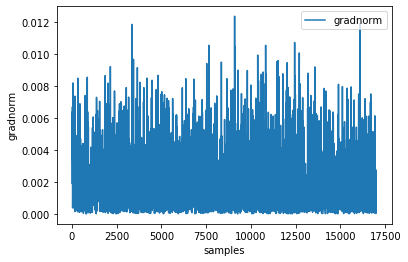

0.0020635944910445394


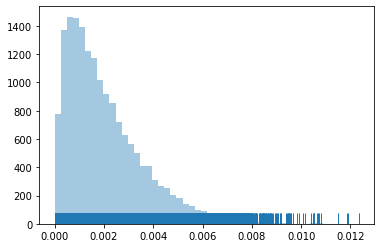

In [48]:
loss_test_plot = plt.plot(loss, label = 'gradnorm')
plt.legend()
plt.ylabel('gradnorm')
plt.xlabel('samples')
plt.show()
tot_error = np.mean(loss)
print(tot_error)
import seaborn as sns
x = loss
sns.distplot(x, bins=50, kde=False, rug=True)

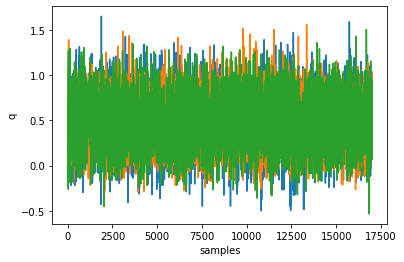

0.49351787116148177


(17000, 3)

In [50]:
loss_test_plot = plt.plot(q[:, 0:3], label = 'q')
plt.ylabel('q')
plt.xlabel('samples')
plt.show()
tot_error = np.mean(q)
print(tot_error)
q.shape

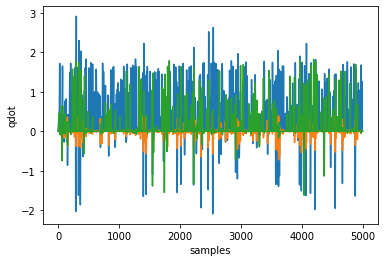

0.21462562142634448


In [25]:
loss_test_plot = plt.plot(qdot[:, 0:3], label = 'qdot')
plt.ylabel('qdot')
plt.xlabel('samples')
plt.show()
tot_error = np.mean(qdot)
print(tot_error)

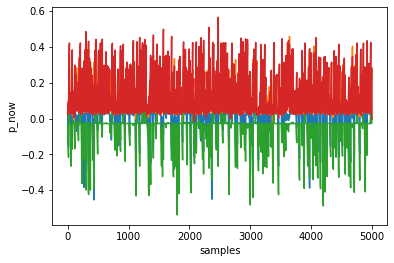

In [26]:
loss_test_plot = plt.plot(p_now, label = 'p_now')
plt.ylabel('p_now')
plt.xlabel('samples')
plt.show()
tot_error = np.mean(p_now)

In [5]:
test = y_target[0:1000, :]- y_target[3000:4000]
test = test[~(test == 0).all(1)]
test

array([[-1.62133541,  0.69803752, -0.50799517],
       [-0.85032046, -0.49941502,  0.61089457],
       [-0.00802707,  0.33019332, -0.11704796],
       ...,
       [-0.23355374,  0.12606274,  0.10735312],
       [ 1.86218035, -1.77482782,  0.70986122],
       [ 0.75887475,  0.39944588, -0.43563535]])

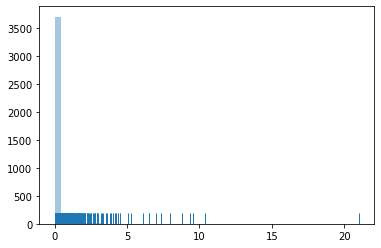

In [21]:
import seaborn as sns
x = p_now[:, 1]
sns.distplot(x, bins=50, kde=False, rug=True)